**In this lab, you will understand how to divide a task into smaller tasks, do parallel processing and then aggregate results**

In some usecases , we need to do  task decomposition and parallel processing.

This approach involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.

Following is the usecase:

Given a general topic from the user, generate a list of related subjects, generate a joke for each subject, and select the best joke from the resulting list.

In this design pattern, a first node may generate a list of objects (e.g., related subjects) and we want to apply some other node (e.g., generate a joke) to all those objects (e.g., subjects)

Challenges:



1.   the number of objects (e.g., subjects) may be unknown ahead of time (meaning the number of edges may not be known) when we lay out the graph  

2.    the input State to the downstream Node should be different (one for each generated object).


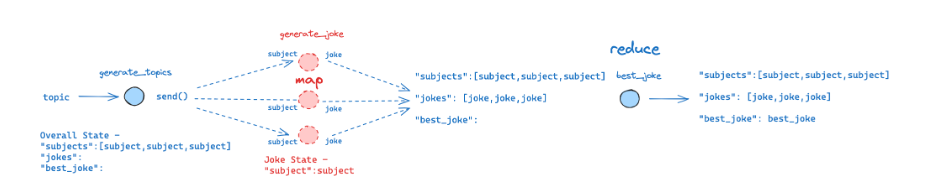

In [1]:
#pip install langchain langchain_core  langchain_openai  langgraph langchain_community langchain_experimental langchainhub python-dotenv bs4

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from typing import List, Sequence



from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph, MessagesState
from langgraph.graph.message import MessagesState


In [4]:
import operator
from typing import Annotated, TypedDict

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

import threading


model = ChatOpenAI(model="gpt-4o-mini")

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke")

In [5]:
# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str

In [6]:
# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    thread_name = threading.current_thread().name
    print(f"Thread name: {thread_name}..inside generate_topics")
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    thread_name = threading.current_thread().name
    print(f"Thread name: {thread_name}.... inside generate_joke")
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    thread_name = threading.current_thread().name
    print(f"Thread name: {thread_name}.... continue_to_jokes")

    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    thread_name = threading.current_thread().name
    print(f"Thread name: {thread_name}.... best_joke")
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.invoke(prompt)
    return {"best_selected_joke": response.content}
   #response = model.with_structured_output(BestJoke).invoke(prompt)
   # return {"best_selected_joke": state["jokes"][response.id]}

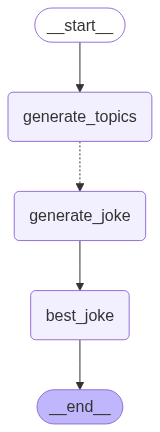

In [7]:
graph = StateGraph(state_schema=OverallState)


graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [8]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "Animals"}):
    print(s)

Thread name: MainThread..inside generate_topics
Thread name: MainThread.... continue_to_jokes
{'generate_topics': {'subjects': ['Lion', 'Elephant', 'Dolphin', 'Giraffe']}}
Thread name: ThreadPoolExecutor-1_0.... inside generate_joke
Thread name: ThreadPoolExecutor-1_2.... inside generate_joke
Thread name: ThreadPoolExecutor-1_1.... inside generate_joke
Thread name: ThreadPoolExecutor-1_3.... inside generate_joke
{'generate_joke': {'jokes': ['Why do giraffes have such long necks? \n\nBecause their feet smell!']}}
{'generate_joke': {'jokes': ['Why do elephants never use computers? \n\nBecause they’re afraid of the mouse!']}}
{'generate_joke': {'jokes': ["Why don't lions ever play cards in the jungle? \n\nBecause there are too many cheetahs!"]}}
{'generate_joke': {'jokes': ['Why did the dolphin bring a towel to the party? \n\nBecause he wanted to have a whale of a time without getting too wet!']}}
Thread name: MainThread.... best_joke
{'best_joke': {'best_selected_joke': 'The best joke fr